# Generating Audio Timbres with a Neural Cellular Automata 🎶

This notebook demonstrates how to "grow" a sound that mimics the timbre of a target audio file using a Textured Neural Cellular Automata (TNCA).

**Workflow:**
1.  **Setup**: Install and import necessary libraries.
2.  **Configuration**: Set parameters for audio processing and model training.
3.  **Load Data**: Upload a target audio file (e.g., a short violin recording). The script will convert it into a mel spectrogram, which is a visual fingerprint of the sound.
4.  **Train Model**: The TNCA model will learn the rules to generate a spectrogram that looks and sounds like the target.
5.  **Inference**: The trained model generates a final spectrogram, which is converted back into an audio file you can listen to.

In [9]:
# Install necessary libraries
!pip install librosa soundfile
!pip install speechbrain

# Import all required modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import soundfile as sf
import os

# --- Device Configuration ---
print(f"PyTorch version: {torch.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu126
Torchaudio version: 2.8.0+cu126
Using device: cuda


In [21]:
class Config:
    SAMPLE_RATE = 22050
    N_FFT = 1024
    HOP_LENGTH = 256
    N_MELS = 80 # Changed from 128 to 80 to match HiFi-GAN input requirements
    # Channel 0 is 'value' (spectrogram), Channel 1 is 'alpha' (life).
    CELL_CHANNELS = 16
    UPDATE_STEPS_TRAIN = 96
    UPDATE_STEPS_INFERENCE = 96 # Increased for more detailed generation
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 8000
    LOG_INTERVAL = 100
    OUTPUT_IMAGE_DIR = 'training_progress'

In [11]:
def create_auditory_grid(audio_path, config):
    """Loads an audio file and converts it into a mel-spectrogram."""
    waveform, sr = librosa.load(audio_path, sr=config.SAMPLE_RATE, mono=True)

    # --- START: NEW PADDING LOGIC ---
    # The HiFi-GAN model requires the time dimension of the spectrogram to be a multiple of 8.
    # We add padding to the raw waveform to ensure this.

    # Calculate the number of samples needed for the spectrogram time dimension to be a multiple of 8
    n_frames = len(waveform) / config.HOP_LENGTH
    if n_frames % 8 != 0:
        target_frames = int(np.ceil(n_frames / 8.0)) * 8
        target_samples = target_frames * config.HOP_LENGTH

        # Pad the waveform with silence (zeros)
        padding_needed = target_samples - len(waveform)
        waveform = np.pad(waveform, (0, padding_needed), 'constant')
    # --- END: NEW PADDING LOGIC ---

    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform, sr=config.SAMPLE_RATE, n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH, n_mels=config.N_MELS
    )
    # Convert power spectrogram to decibels
    return librosa.power_to_db(mel_spectrogram, ref=np.max)

def visualize_spectrogram(spectrogram, config, title='Mel-Spectrogram', output_path=None):
    """Visualizes a mel-spectrogram."""
    plt.figure(figsize=(12, 5))

    # Ensure spectrogram is a numpy array on the CPU for plotting
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.detach().cpu().numpy()

    librosa.display.specshow(spectrogram, sr=config.SAMPLE_RATE, hop_length=config.HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [12]:
import torch
from speechbrain.pretrained import HIFIGAN

# This will download the pre-trained model (once) and cache it
hifigan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-ljspeech", # <-- This is the corrected model path
    savedir="pretrained_models/hifigan-ljspeech"
).to(device)

hifigan.eval()
print("SpeechBrain HiFi-GAN vocoder loaded successfully.")

class TNCAModel(nn.Module):
    def __init__(self, num_channels=16):
        super().__init__()
        self.num_channels = num_channels

        # Perception vector size: original channels + Sobel X + Sobel Y + Laplacian
        perception_vector_size = self.num_channels * 4

        self.update_mlp = nn.Sequential(
            nn.Conv2d(perception_vector_size, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, self.num_channels, 1, bias=True)
        )
        # Initialize the last layer to zeros to encourage a stable initial state
        self.update_mlp[-1].weight.data.zero_()
        self.update_mlp[-1].bias.data.zero_()
        # Set the bias for the alpha channel to 1.0 to prevent immediate death
        self.update_mlp[-1].bias.data[1] = 1.0

    def perceive(self, grid):
        # Define fixed, non-trainable filters for perception
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
        sobel_y = sobel_x.T.contiguous().view(1, 1, 3, 3)
        laplacian = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)

        # Create kernels for group convolution (apply filters to each channel independently)
        sobel_x_kernel = sobel_x.repeat(self.num_channels, 1, 1, 1)
        sobel_y_kernel = sobel_y.repeat(self.num_channels, 1, 1, 1)
        laplacian_kernel = laplacian.repeat(self.num_channels, 1, 1, 1)

        # Apply filters
        grad_x = F.conv2d(grid, sobel_x_kernel, padding=1, groups=self.num_channels)
        grad_y = F.conv2d(grid, sobel_y_kernel, padding=1, groups=self.num_channels)
        lap = F.conv2d(grid, laplacian_kernel, padding=1, groups=self.num_channels)

        # Concatenate the original grid with the perceived information
        return torch.cat([grid, grad_x, grad_y, lap], dim=1)

    def forward(self, grid):
        perception_vector = self.perceive(grid)
        ds = self.update_mlp(perception_vector) # Get the update vector

        # Deterministic update (no stochastic mask)
        grid = grid + ds

        # Ensure alpha channel is differentiable and clamped between 0 and 1
        clamped_alpha = torch.clamp(grid[:, 1:2, :, :], 0.0, 1.0)
        grid = torch.cat([grid[:, :1, :, :], clamped_alpha, grid[:, 2:, :, :]], dim=1)

        # A differentiable "living mask" based on the alpha channel
        alpha_channel = grid[:, 1:2, :, :]
        living_mask = F.max_pool2d(alpha_channel, kernel_size=3, stride=1, padding=1)

        # Apply the living mask to all channels
        grid = grid * living_mask

        return grid

class GriffinLimVocoder(nn.Module):
    """Converts a mel-spectrogram back to an audio waveform."""
    def __init__(self, config):
        super().__init__()
        self.griffin_lim = torchaudio.transforms.GriffinLim(
            n_fft=config.N_FFT, hop_length=config.HOP_LENGTH, power=2.0).to(device)
        self.inverse_mel_scale = torchaudio.transforms.InverseMelScale(
            n_stft=config.N_FFT // 2 + 1, n_mels=config.N_MELS,
            sample_rate=config.SAMPLE_RATE, driver='gels').to(device) # Changed driver to 'gels' and moved to device

    def forward(self, mel_spectrogram_power):
        # Convert power spectrogram to magnitude
        mel_spectrogram_magnitude = torch.sqrt(mel_spectrogram_power.clamp(min=1e-10))

        # Add a tiny bit of noise for stability
        noise = torch.rand_like(mel_spectrogram_magnitude) * 1e-5
        stable_mel_spec = torch.clamp(mel_spectrogram_magnitude + noise, min=1e-5)

        # Invert the mel scale to get a linear-frequency spectrogram
        stft_magnitude = self.inverse_mel_scale(stable_mel_spec)

        # Apply Griffin-Lim to reconstruct the waveform
        return self.griffin_lim(stft_magnitude.pow(2))

class PerceptualLoss(nn.Module):
    """A loss based on the Gram matrix of feature maps from a pretrained CNN."""
    def __init__(self):
        super().__init__()
        # A simple feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 7, 2, 3), nn.ReLU(), nn.Conv2d(16, 32, 5, 2, 2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU()).to(device)

    def gram_matrix(self, f):
        b, c, h, w = f.size()
        f = f.view(b, c, h * w)
        # Compute the Gram matrix
        return torch.bmm(f, f.transpose(1, 2)) / (c * h * w)

    def forward(self, gen_mel, target_mel):
        # Compare the Gram matrices of the generated and target feature maps
        return F.mse_loss(self.gram_matrix(self.feature_extractor(gen_mel)),
                          self.gram_matrix(self.feature_extractor(target_mel)))

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/hifigan-ljspeech/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-ljspeech' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/hifigan-ljspeech.
INFO:speechbrain.utils.fetching:Fetch generator.ckpt: Using symlink found at '/content/pretrained_models/hifigan-ljspeech/generator.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["generator"] = /content/pretrained_models/hifigan-ljspeech/generator.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: generator
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): generator -> /content/pretrained_models/hifigan-ljspeech/generator.ckpt


SpeechBrain HiFi-GAN vocoder loaded successfully.


In [16]:
def train(model, vocoder, loss_fn, optimizer, target_mel, config):
    print("\n--- Starting Training ---")
    perceptual_loss_fn = loss_fn
    l1_loss_fn = nn.L1Loss()

    target_mel_tensor = torch.tensor(target_mel, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)

    # A mask to compute loss only on non-silent parts of the target
    target_mask = (target_mel_tensor > -70.0).float()

    # Weight loss higher for higher frequencies, which are often harder to learn
    n_mels = target_mel_tensor.shape[2]
    frequency_loss_weights = torch.linspace(1.0, 2.0, n_mels, device=device).view(1, 1, n_mels, 1)

    # Initialize the seed grid: a tensor of zeros with a single "alive" cell in the center
    seed_grid = torch.zeros(1, config.CELL_CHANNELS, config.N_MELS, target_mel.shape[1], device=device)
    h, w = seed_grid.shape[2], seed_grid.shape[3]
    seed_grid[:, 1, h//2, w//2] = 1.0 # Set alpha of center pixel to 1

    pbar = tqdm(range(config.NUM_EPOCHS), desc="Training...")

    for epoch in pbar:
        grid = seed_grid.clone()
        # Evolve the grid for a fixed number of steps
        for _ in range(config.UPDATE_STEPS_TRAIN):
            grid = model(grid)

        # Extract the "value" channel (index 0) and scale it to the dB range
        generated_mel_db_unscaled = grid[:, 0:1, :, :]
        generated_mel_db = torch.tanh(generated_mel_db_unscaled) * 40.0 - 40.0

        # Apply the target mask to the generated spectrogram

        # Calculate losses
        p_loss = perceptual_loss_fn(generated_mel_db * target_mask, target_mel_tensor * target_mask)
        l1_loss = l1_loss_fn(generated_mel_db * target_mask, target_mel_tensor * target_mask)
        # Combine losses, applying frequency weights
        loss = (2.0*p_loss + 0.1 * l1_loss) * frequency_loss_weights
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Logging and saving progress images
        if (epoch + 1) % config.LOG_INTERVAL == 0:
            pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.6f} (P: {p_loss.item():.6f}, L1: {l1_loss.item():.6f})")
            filepath = os.path.join(config.OUTPUT_IMAGE_DIR, f'epoch_{(epoch+1):04d}.png')
            visualize_spectrogram(generated_mel_db.squeeze(), config,
                                  title=f'Generated Spectrogram - Epoch {epoch+1}',
                                  output_path=filepath)

    print(f"\nTraining complete. Final loss: {loss.item():.6f}")
    return model

# Fix 2: Update your inference function to ensure proper device handling
def inference(model, vocoder, target_mel, config, output_path='generated_timbre.wav'):
    print("\n--- Running Inference ---")

    model.eval()

    # Ensure target_mel is a tensor on the correct device
    if isinstance(target_mel, np.ndarray):
        target_mel = torch.tensor(target_mel, dtype=torch.float32, device=device)
    else:
        target_mel = target_mel.to(device)

    # Initialize seed grid
    seed_grid = torch.zeros(1, config.CELL_CHANNELS, config.N_MELS, target_mel.shape[1], device=device)
    h, w = seed_grid.shape[2], seed_grid.shape[3]
    seed_grid[:, 1, h//2, w//2] = 1.0

    with torch.no_grad():
        final_grid = seed_grid.clone()
        for _ in tqdm(range(config.UPDATE_STEPS_INFERENCE), desc="Generating..."):
            final_grid = model(final_grid)

        # Extract and scale
        final_mel_db_unscaled = final_grid[:, 0, :, :]
        final_mel_db = torch.tanh(final_mel_db_unscaled) * 40.0 - 40.0

        # Convert to power spectrum
        mel_spec_power = torch.pow(10.0, final_mel_db / 10.0)

        print(f"Shape before vocoder: {mel_spec_power.shape}")

        # SOLUTION: Move vocoder to CPU and process there
        print("Moving vocoder to CPU for inference...")
        vocoder_cpu = vocoder.to('cpu')
        mel_spec_power_cpu = mel_spec_power.cpu()

        # Call vocoder on CPU
        final_waveform = vocoder_cpu.decode_batch(mel_spec_power_cpu)

        # Move vocoder back to GPU if needed
        vocoder.to(device)

    # Save audio
    sf.write(output_path, final_waveform.squeeze().cpu().numpy(), config.SAMPLE_RATE)
    print(f"Inference complete. Audio saved to: {output_path}")
    visualize_spectrogram(final_mel_db.squeeze().cpu(), config, title='Final Generated Spectrogram')

Target Spectrogram:


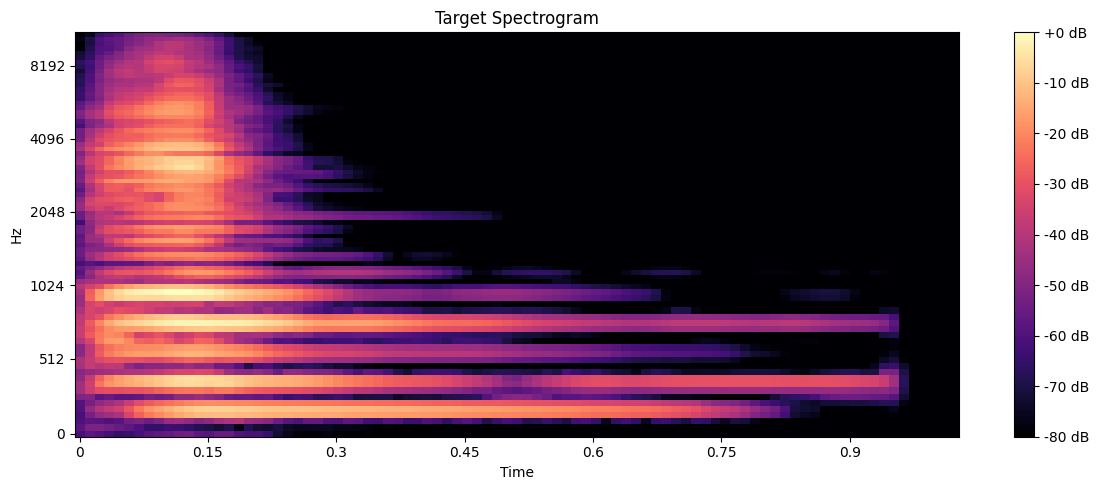


--- Starting Training ---


Training...:   0%|          | 0/8000 [00:00<?, ?it/s]


Training complete. Final loss: 0.083218

--- Running Inference ---


Generating...:   0%|          | 0/96 [00:00<?, ?it/s]

Shape before vocoder: torch.Size([1, 80, 89])
Moving vocoder to CPU for inference...
Inference complete. Audio saved to: generated_output.wav


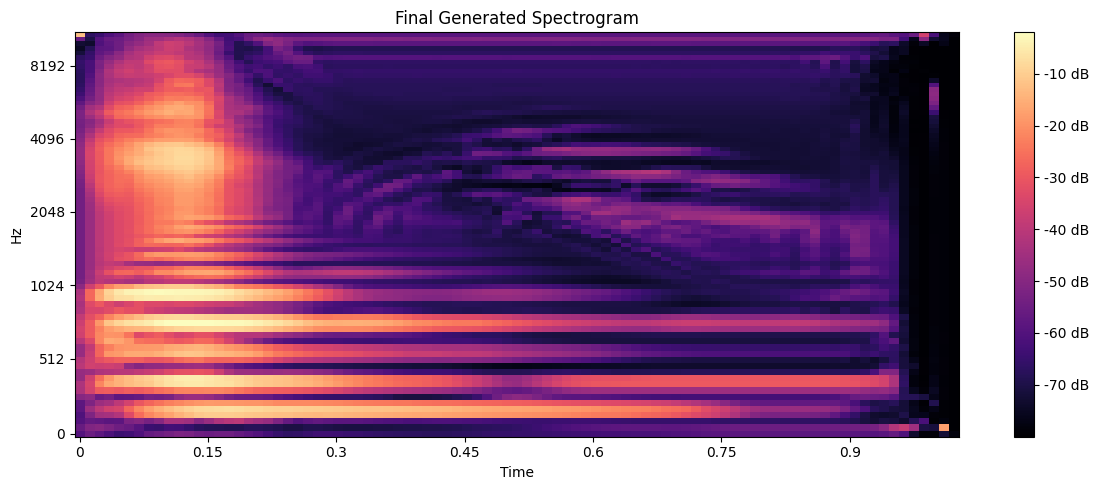

In [22]:
# --- 1. Initialization ---
config = Config()
os.makedirs(config.OUTPUT_IMAGE_DIR, exist_ok=True)
vocoder = GriffinLimVocoder(config).to(device)

# --- 2. Load Target Audio and Create Spectrogram ---
# IMPORTANT: Upload your own .wav file and update the path below!
target_audio_path = 'violin.wav' # <--- CHANGE THIS TO YOUR FILENAME

# Fix 3: Update your main execution code
if not os.path.exists(target_audio_path):
    print(f"ERROR: Audio file not found at '{target_audio_path}'")
    print("Please upload the file to your Colab session and try again.")
else:
    # Create target spectrogram (this returns a NumPy array)
    target_spectrogram = create_auditory_grid(target_audio_path, config)
    print("Target Spectrogram:")
    visualize_spectrogram(target_spectrogram, config, title='Target Spectrogram')

    # Initialize models
    tnca_model = TNCAModel(config.CELL_CHANNELS).to(device)
    perceptual_loss_fn = PerceptualLoss().to(device)
    optimizer = optim.Adam(tnca_model.parameters(), lr=config.LEARNING_RATE)

    # Ensure vocoder is on correct device
    hifigan = hifigan.to(device)

    # Train the model (pass NumPy array, conversion happens inside train function)
    trained_model = train(tnca_model, vocoder, perceptual_loss_fn, optimizer, target_spectrogram, config)

    # Run inference (pass NumPy array, conversion happens inside inference function)
    inference(trained_model, hifigan, target_spectrogram, config, output_path='generated_output.wav')